In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.neighbors import KNeighborsClassifier

# Draw inline
%matplotlib inline

# Disable warnings from printing
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
# Read the data
train_users = pd.read_csv('../Data/train_users.csv')
test_users = pd.read_csv('../Data/test_users.csv')

# Drop country for processing
LABEL = 'country_destination'
labels = train_users[LABEL].copy()
train_users.drop(LABEL, inplace=True, axis=1)

# Merge train and test users
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

# Fill null with -1 for missing values
users.fillna(-1, inplace=True)

# Drop id for processing
ids = users["id"].copy()
users.drop("id", inplace=True, axis=1)

In [8]:
CATEGORICAL_FEATURES = ['affiliate_channel', 'affiliate_provider',
                        'first_affiliate_tracked', 'first_browser',
                        'first_device_type', 'gender', 'language', 'signup_app',
                        'signup_method', 'signup_flow']

# A parameter to speed-up computation and avoid overfitting.
# Categorical values that appear less than the threshold will be removed.
THRESHOLD = 0.001*users.shape[0]

for feature in CATEGORICAL_FEATURES:
    counts = users[feature].value_counts()
    users[feature] = users[feature].apply(lambda x: 'Other' if counts[x] < THRESHOLD else x)

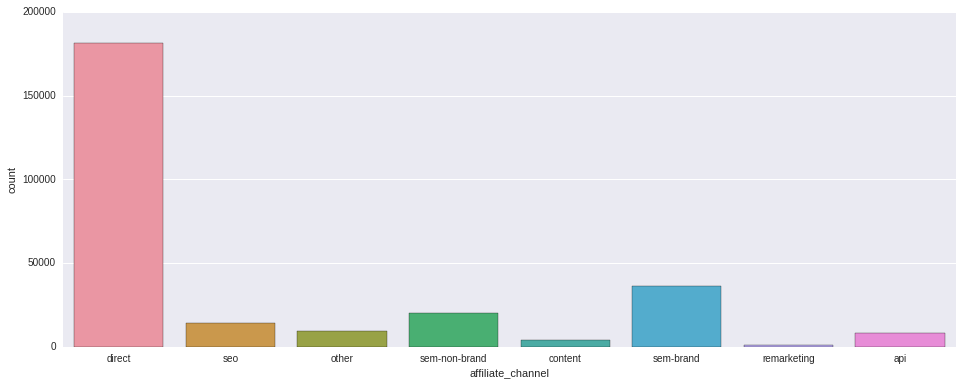

In [9]:
# affiliate_channel processing. No missing values.
plt.rcParams['figure.figsize'] = (16.0, 6.0)
sns.countplot(x='affiliate_channel', data=users)
users.affiliate_channel.describe()

# So can uses simple one hot encoding
users = users.join(pd.get_dummies(users['affiliate_channel'], prefix="affiliate_channel"))
  
# Drop the original columns.
users = users.drop(["affiliate_channel"], axis=1)

# Similarly with affiliate_provider
users = users.join(pd.get_dummies(users['affiliate_provider'], prefix="affiliate_provider"))
users = users.drop(["affiliate_provider"], axis=1)

# first_affiliate_tracked processing
# Fill missing values with mode as they are less and mode is extremely common.
# Then apply one-hot encoding as above
users.loc[users.first_affiliate_tracked.isnull(), 'first_affiliate_tracked'] = \
users.loc[:, 'first_affiliate_tracked'].mode()[0]
users = users.join(pd.get_dummies(users['first_affiliate_tracked'], prefix="first_affiliate_tracked"))
users = users.drop(["first_affiliate_tracked"], axis=1)

# Similarly with first_browser
users = users.join(pd.get_dummies(users['first_browser'], prefix="first_browser"))
users = users.drop(["first_browser"], axis=1)

# Similarly with first_device_type
users = users.join(pd.get_dummies(users['first_device_type'], prefix="first_device_type"))
users = users.drop(["first_device_type"], axis=1)

# Similarly with language
users = users.join(pd.get_dummies(users['language'], prefix="language"))
users = users.drop(["language"], axis=1)

# Similarly with signup_app
users = users.join(pd.get_dummies(users['signup_app'], prefix="signup_app"))
users = users.drop(["signup_app"], axis=1)

# Similarly with signup_flow. It is categorical, page number.
users = users.join(pd.get_dummies(users['signup_flow'], prefix="signup_flow"))
users = users.drop(["signup_flow"], axis=1)

# Similarly with signup_method.
users = users.join(pd.get_dummies(users['signup_method'], prefix="signup_method"))
users = users.drop(["signup_method"], axis=1)

In [10]:
# data_account_created processing
# Extract year, month, day, weekday from dates

DATE_FORMAT = '%Y-%m-%d'

def _parse_date(date_str):
    time_dt = dt.datetime.strptime(date_str, DATE_FORMAT)
    return [time_dt.year, time_dt.month, time_dt.day, time_dt.weekday()]

def extract_dates_inplace(features, date_column):
    extracted_vals = np.vstack(features[date_column].apply(
        (lambda x: _parse_date(x))))
    for i, period in enumerate(['year', 'month', 'day', 'weekday']):
        features['%s_%s' % (date_column, period)] = extracted_vals[:, i]
    features.drop(date_column, inplace=True, axis=1)
    
extract_dates_inplace(users, "date_account_created")

# Since date_first_booking is null for entire test data, we can simply drop it.
# Dropping timestamp_first_active for now
users.drop(['timestamp_first_active', 'date_first_booking'], inplace=True, axis=1)

In [11]:
# Age is missing for values -1, and spurious values > 95 or < 13
users.age[users.age > 95] = -1
users.age[users.age < 13] = -1

# Now for all missing age values (-1), predict them using KNN
# Augment data with id for original order of records
users["tempIdx"] = users.index

# Get records with age = -1
query_matrix = users[users.age == -1]
    
# Get records with age != -1
search_matrix = users[users.age != -1]

# Predict age using KNN
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(search_matrix.loc[:, "affiliate_channel_api":"date_account_created_weekday"], search_matrix['age'])
query_matrix['age'] = clf.predict(query_matrix.loc[:, "affiliate_channel_api":"date_account_created_weekday"])

# Construct data to original form and order
users = pd.concat((search_matrix, query_matrix), ignore_index=True)
users = users.sort_values(["tempIdx"]).reset_index()
users.drop(["index"], axis=1, inplace=True)
users.drop(["tempIdx"], axis=1, inplace=True)

In [12]:
# Similarly for gender
# Augment data with id for original order of records
users["tempIdx"] = users.index

# Get records with gender="-unknown-"
query_matrix = users[users.gender == "-unknown-"]
    
# Get records with age != -1
search_matrix = users[users.gender != "-unknown-"]

# Predict age using KNN
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(search_matrix.loc[:, "age":"date_account_created_weekday"], search_matrix['gender'])
query_matrix['gender'] = clf.predict(query_matrix.loc[:, "age":"date_account_created_weekday"])

# Construct data to original form and order
users = pd.concat((search_matrix, query_matrix), ignore_index=True)
users = users.sort_values(["tempIdx"]).reset_index()
users.drop(["index"], axis=1, inplace=True)
users.drop(["tempIdx"], axis=1, inplace=True)

# One hot encoding for gender
users = users.join(pd.get_dummies(users['gender'], prefix="gender"))
users = users.drop(["gender"], axis=1)

In [18]:
# Re attach the ids
users = pd.concat((users, ids), axis=1)

# Save processed training and testing data.
training = users[:train_users.shape[0]]
testing = users[train_users.shape[0]:]

TRAINING_FINAL_CSV_FILE = '../Data/train_users_processed.csv'
TESTING_FINAL_CSV_FILE = '../Data/test_users_processed.csv'
LABELS_FINAL_CSV_FILE = '../Data/labels.csv'

training.to_csv(TRAINING_FINAL_CSV_FILE, header=True, ignore_index=True)
testing.to_csv(TESTING_FINAL_CSV_FILE, header=True)
labels.to_csv(LABELS_FINAL_CSV_FILE, header=True)